In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from pylab import *
import numpy as np
from tensorflow import keras
from sklearn.metrics import mean_absolute_error

This notebook corresponds to the experiments run for the 2.1 section of the vision paper "Is Machine Learning Necessary for Cloud Resource Usage Forecasting?". The models used for inference are the ones deployed in the cloud-forecast-lstm repository that can be found here: https://github.com/muse-research-lab/cloud-forecast-lstm. 

We conduct three sets of experiments, that define different test datasets to use during inference over the trained models, where there is one model per job. In more detail:
• Experiment A defines as test dataset the data used during training, to evaluate the achieved prediction accuracy per model.
• Experiment B uses as test data the time series of 10 randomly selected tasks of the same job, excluding the training data,running inference with the model corresponding to the same job.
• Experiment C uses the trained model of the job with identifier 113, to run inference against test data of 10 tasks belonging to the other jobs, namely 374, 399, 917 (x-axis).

We generate three plots, that correspond to each experiment and capture the resource usage prediction error when using ML models (LSTMs) vs a non-ML prediction. More details on the non-ML prediction can be found in section 3.1 of the paper under the paragraph Data Persistence Metric.

In [2]:
job_ids = ['113812204462', '374877055556', '399444405700', '91724979887']
job_labels = ['113', '374', '399', '917']

In [3]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence) - 1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [4]:
s1_all_results = []
s1_all_lstm_mae = []
s1_all_previous_mae = []

s2_all_results = []
s2_all_lstm_mae = []
s2_all_previous_mae = []

s3_all_results = []
s3_all_lstm_mae = []
s3_all_previous_mae = []

In [5]:
for ind, job_id in enumerate(job_ids):
    job_label = job_labels[ind]
    columns_to_use = ['avg_cpu_usage', 'time']
    time_col = 'time'
    col = 'avg_cpu_usage'
    time_unit = 'us'
    freq = '5min'

    # folder path
    dir_path = r'input-large/' + job_id + '/'

    # list to store files
    list_of_files = []

    # Iterate directory
    for path in os.listdir(dir_path):
        # check if current path is a file
        if os.path.isfile(os.path.join(dir_path, path)):
            list_of_files.append(path)
                    
    csv_data_list = []
    for i in list_of_files:
        type(i)
        dir = 'input-large/' +job_id + '/' + i 
        csv_data_list.append(pd.read_csv(filepath_or_buffer=dir, usecols=columns_to_use))

    data = []
    for df in csv_data_list:
        df[time_col] = pd.to_datetime(
        df[time_col], unit=time_unit)
        df.set_index(time_col, inplace=True)
        df = df[~df.index.duplicated(keep="first")]
        df = df.resample(freq).mean()
        df = df.asfreq(freq=freq, method="ffill")
        df = df.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)
        data.append(df)
    
    for mod_index, model_id in enumerate(job_ids):
        model_label = job_labels[mod_index]
        number_of_tasks = len(list_of_files)
        avg_res = []
        for i in range (0, number_of_tasks):
            x_test = data[i][:800]['avg_cpu_usage']
            n_features = 1
            n_steps = 30

            a = min(x_test)
            b = max(x_test)
            x_test_normalised = []
            for x in x_test:
                x_test_normalised.append(((x-a)/(b-a)))

            # split into samples
            X_test, y_test = split_sequence(x_test_normalised, n_steps)
            X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))
                            
            model = keras.models.load_model('pretrained_lstm_models/job' + model_label + '/newbaseline_model/model')
            m = model
            yh = m.predict(X_test, verbose=0)
            
            result = []
            for item1, item2 in zip(yh[0:600], x_test_normalised[30:630]):
                result.append(np.abs(item1-item2))

            mae_lstm = mean_absolute_error(x_test_normalised[30:630], yh[0:600])
            mae_previous = mean_absolute_error(x_test_normalised[30:630], x_test_normalised[31:631])
            
            #experiment C
            if(mod_index==0):
                s3_all_previous_mae.append(mae_previous)

            s3_all_results.append(result)
            s3_all_lstm_mae.append(mae_lstm)

            if (i == 0 and model_id == job_id):
                #experiment A
                s1_all_results.append(result)
                s1_all_lstm_mae.append(mae_lstm)
                s1_all_previous_mae.append(mae_previous)

            if (model_id == job_id):
                #experiment B
                s2_all_results.append(result)
                s2_all_lstm_mae.append(mae_lstm)
                s2_all_previous_mae.append(mae_previous)

            y_denorm = []
            for y in yh:
                y_denorm.append(y*((b)-(a)) + (a))
            
            fig, ax = plt.subplots()
            fig.set_size_inches(35, 9)
            ax.set_xlabel('Time (hours)', size = 45)
            
            plt.xticks(size = 45)
            plt.yticks(size = 45)
            x_ticks = [0, 60, 120, 180]
            x_labels = [0, 8, 16, 24]
            plt.xticks(ticks=x_ticks, labels=x_labels)
            y_ticks = [0.010, 0.013, 0.016, 0.019 ,0.022, 0.027, 0.3, 0.35, 0.4, 0.045, 0.05, 0.055, 0.06, 0.065]
            plt.yticks(ticks=y_ticks, labels=y_ticks) 
            plt.ylabel("AVG CPU usage (%)", size = 45)
            ax.tick_params(width=4)
            bins = np.linspace(0, 100, 100)
            
            plt.plot(bins, y_denorm[0:100], alpha=1, color="#923b62",label='ML prediction')
            plt.plot(bins, x_test[29:129], alpha=1, color="#e6ae65",label='non-ML prediction')
            plt.plot(bins, x_test[30:130], alpha=1, color="#1e256c",label='ground truth')
            plt.legend(loc="upper right", prop={'size': 45})
            plt.savefig('Inference of job ' + job_label + ' using ' + model_id + 'task' + str(i) + ' model' +'.pdf', bbox_inches='tight')
            plt.close()

2023-09-18 10:43:58.909112: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Experiment A

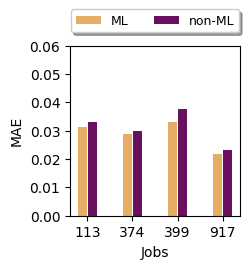

In [6]:
fig = plt.figure(figsize=(1.7,1.7))
ax = fig.add_axes([0,0,1,1])

methods = ['113', '374', '399', '917']

x = np.arange(4)
y1 = s1_all_lstm_mae
y2 = s1_all_previous_mae
width = 0.2
  
plt.bar(x-0.11, y1, width, color="#e6ae65")
plt.bar(x+0.11, y2, width, color="#69105e")

plt.xticks(x, methods, size = 10)
plt.yticks(size = 10)
plt.xlabel("Jobs", size = 10)
plt.ylabel("MAE", size = 10)
plt.ylim(0, 0.06)

plt.legend(["ML", "non-ML"],fontsize = 9,loc='upper center', bbox_to_anchor=(0.5, 1.25),
          fancybox=True, shadow=True, ncol=2)
plt.show()

Experiment B

In [8]:
mae_s2 = []
mae_s2_error = []

mae_s2.append(np.mean(np.array(s2_all_lstm_mae[0:10])))
mae_s2_error.append(np.std(s2_all_lstm_mae[0:10]))

mae_s2.append(np.mean(np.array(s2_all_lstm_mae[10:20])))
mae_s2_error.append(np.std(s2_all_lstm_mae[10:20]))

mae_s2.append(np.mean(np.array(s2_all_lstm_mae[20:30])))
mae_s2_error.append(np.std(s2_all_lstm_mae[20:30]))

mae_s2.append(np.mean(np.array(s2_all_lstm_mae[30:40])))
mae_s2_error.append(np.std(s2_all_lstm_mae[30:40]))

In [9]:
mae_s2_previous = []
mae_s2_error_previous = []

mae_s2_previous.append(np.mean(np.array(s2_all_previous_mae[0:10])))
mae_s2_error_previous.append(np.std(s2_all_previous_mae[0:10]))

mae_s2_previous.append(np.mean(np.array(s2_all_previous_mae[10:20])))
mae_s2_error_previous.append(np.std(s2_all_previous_mae[10:20]))

mae_s2_previous.append(np.mean(np.array(s2_all_previous_mae[20:30])))
mae_s2_error_previous.append(np.std(s2_all_previous_mae[20:30]))

mae_s2_previous.append(np.mean(np.array(s2_all_previous_mae[30:40])))
mae_s2_error_previous.append(np.std(s2_all_previous_mae[30:40]))

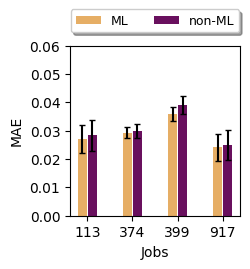

In [10]:
fig = plt.figure(figsize=(1.7,1.7))
ax = fig.add_axes([0,0,1,1])

methods = ['113', '374', '399', '917']

x = np.arange(4)
y1 = mae_s2
y2 = mae_s2_previous
width = 0.2

plt.bar(x-0.11, y1, width, color="#e6ae65", yerr=mae_s2_error, align='center', ecolor='black', capsize=2)
plt.bar(x+0.11, y2, width, color="#69105e", yerr=mae_s2_error_previous, align='center', ecolor='black', capsize=2)
plt.xticks(x, methods, size = 10)
plt.yticks(size = 10)
plt.xlabel("Jobs", size = 10)
plt.ylabel("MAE", size = 10)
plt.ylim(0, 0.06)

plt.legend(["ML", "non-ML"],fontsize = 9,loc='upper center', bbox_to_anchor=(0.5, 1.25),
          fancybox=True, shadow=True, ncol=2)
plt.show()

Experiment C

In [14]:
mae_s3 = []
mae_s3_error = []

mae_s3.append(np.mean(np.array(s3_all_lstm_mae[10:20])))
mae_s3_error.append(np.std(s3_all_lstm_mae[10:20]))

mae_s3.append(np.mean(np.array(s3_all_lstm_mae[20:30])))
mae_s3_error.append(np.std(s3_all_lstm_mae[20:30]))

mae_s3.append(np.mean(np.array(s3_all_lstm_mae[30:40])))
mae_s3_error.append(np.std(s3_all_lstm_mae[30:40]))


mae_s3_previous = []
mae_s3_error_previous = []

mae_s3_previous.append(np.mean(np.array(s3_all_previous_mae[10:20])))
mae_s3_error_previous.append(np.std(s3_all_previous_mae[10:20]))

mae_s3_previous.append(np.mean(np.array(s3_all_previous_mae[20:30])))
mae_s3_error_previous.append(np.std(s3_all_previous_mae[20:30]))

mae_s3_previous.append(np.mean(np.array(s3_all_previous_mae[30:40])))
mae_s3_error_previous.append(np.std(s3_all_previous_mae[30:40]))

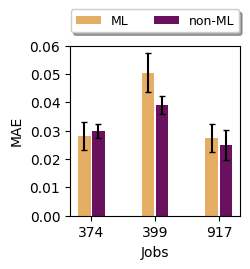

In [15]:
fig = plt.figure(figsize=(1.7,1.7))
ax = fig.add_axes([0,0,1,1])

methods = ['374', '399', '917']

x = np.arange(3)
y1 = mae_s3
y2 = mae_s3_previous
width = 0.2
  
plt.bar(x-0.11, y1, width, color="#e6ae65", yerr=mae_s3_error, align='center', ecolor='black', capsize=2)
plt.bar(x+0.11, y2, width, color="#69105e", yerr=mae_s3_error_previous, align='center', ecolor='black', capsize=2)
plt.xticks(x, methods, size = 10)
plt.yticks(size = 10)
plt.xlabel("Jobs", size = 10)
plt.ylabel("MAE", size = 10)
plt.ylim(0, 0.06)

plt.legend(["ML", "non-ML"],fontsize = 9,loc='upper center', bbox_to_anchor=(0.5, 1.25),
          fancybox=True, shadow=True, ncol=2)
plt.show()